<a href="https://colab.research.google.com/github/581-pooja/581-pooja/blob/main/Fake_News_Detection_using_LSTM_in_Tensorflow_and_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importing all the Libraries

In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [83]:
from platform import python_version
print(python_version())

3.7.12


In [84]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

## 2. Exploring Fake News

In [85]:
fake = pd.read_csv('/content/drive/MyDrive/data/Fake.csv')

In [86]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [87]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [88]:
fake['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [89]:
fake['subject'].unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

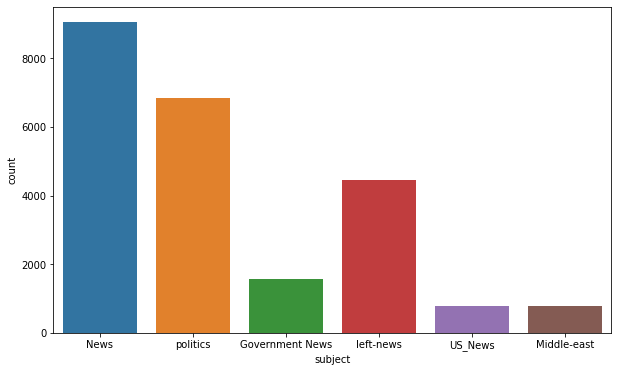

In [90]:
plt.figure(figsize=(10,6))
sns.countplot(x='subject',data=fake)

WordCloud for Fake news

In [91]:
type(fake['text'].tolist())

list

In [92]:
text = ' '.join(fake['text'].tolist())

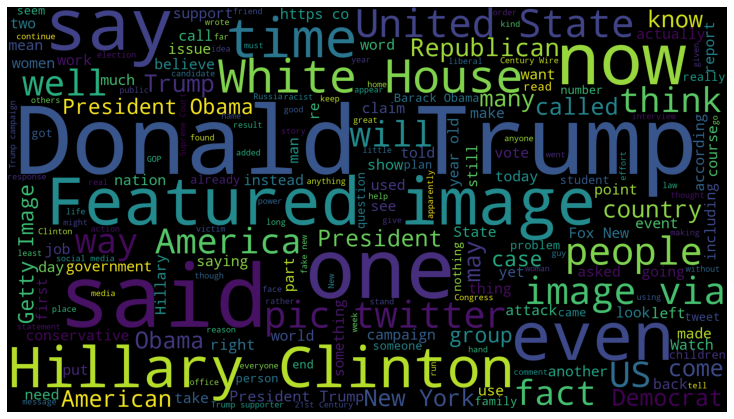

In [93]:
wordcloud = WordCloud(width=1920, height=1080).generate(text)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

From above word cloud we can see the words which are mostly repeated in context of fake news
Most repeated words are United States America , now , Donald Trump since the dataset used for analysis is from US 

### 3. Exploring Fake News

In [94]:
real = pd.read_csv('/content/drive/MyDrive/data/True.csv')

In [95]:
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [96]:
real.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [97]:
real['subject'].value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

WordCloud for Real News

In [98]:
text = ' '.join(real['text'].tolist())

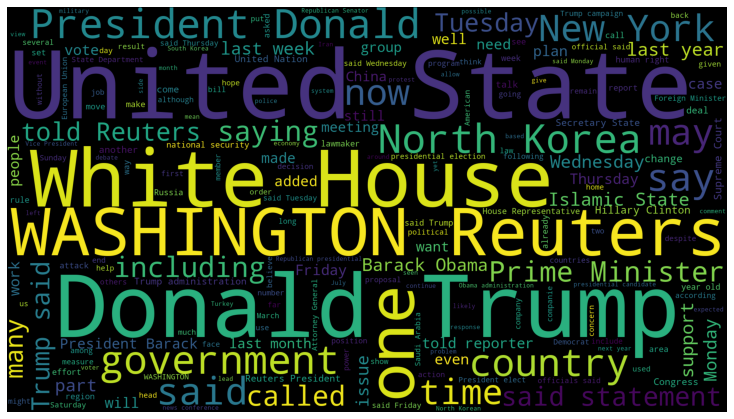

In [99]:
wordcloud = WordCloud(width=1920, height=1080).generate(text)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

From above WordCloud we can see that most repeated words are Washington Reuters, Reuters President and more, from this we can say that publishers are most repeated in Real news

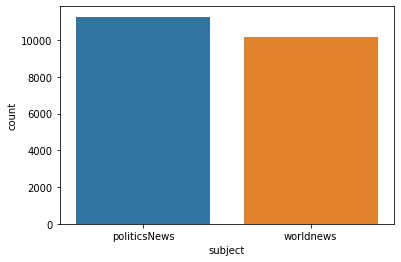

In [100]:
sns.countplot(x='subject',data=real)

In [101]:
real.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

## Difference in Text
Real news seem to have source of publication which is not present in fake news set
Looking at the Data:
- Most of text contains reuters information such as "WASHINGTON (Reuters)".
- Some text are tweets from Twitter
- Few text do not contain any publication info

## Cleaning Data
Removing Reuters or Twitter Tweet information from the text
- Text can be splitted only once at "-" which is always present after mentioning source of publication, this gives us publication part and text part
- If we do not get text part, this means publication details was't given for the record
- The Twitter tweets always have same source, a long text of max 256 characters.

In [102]:
real.sample(5)

,title,text,subject,date
16673,Three-quarters of Australians vote in same-sex...,MELBOURNE (Reuters) - Nearly 12 million Austra...,worldnews,"October 24, 2017"
20628,Turkish minister says EU turning negotiations ...,TALLINN (Reuters) - Turkey said on Friday the ...,worldnews,"September 8, 2017"
20009,"China urges peaceful, diplomatic resolution to...",BEIJING (Reuters) - China s Foreign Ministry s...,worldnews,"September 15, 2017"
10468,"Lawmakers to go to Cuba with Obama, who mulls ...",WASHINGTON (Reuters) - President Barack Obama ...,politicsNews,"March 7, 2016"
1049,"Under Trump plan, refugees from 11 countries f...",WASHINGTON/NEW YORK (Reuters) - The Trump admi...,politicsNews,"October 24, 2017"


In [103]:
# Making a new columns for unKnown_publishers i.e. not having any publisher information by splitting the real news by '-'
unknown_publishers = []
for index, row in enumerate(real.text.values):
    try:
        # Publisher is mentioned in record and taking zeroth column
        record = row.split('-',maxsplit=1)
        # printing the record with index 1 if not present then it will give error
        record[1]
        # Assertions are simply boolean expressions that check if the conditions return true or not. 
        # If it is true, the program does nothing and moves to the next line of code. However, if it's false, the program stops and throws an error.
        assert(len(record[0])<120)
    except:
        unknown_publishers.append(index)

In [104]:
len(unknown_publishers)

222

In [105]:
real.iloc[unknown_publishers].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 222, dtype: object

In [106]:
# Since row 8970 has no data so dropping it
real.iloc[8970]
real = real.drop(8970, axis=0)

In [107]:
real.shape

(21416, 4)

In [108]:
# From text column removing name of publisher and appending in publisher column
# Texts having no publisher then in then appending 'unknown' in publisher column
# Texts having publisher then in then appending 'publisher name' in publisher column

publisher = []
tmp_text = []

for index, row in enumerate(real.text.values):
    if index in unknown_publishers:
        tmp_text.append(row)
        publisher.append('Unknown')
    else:
        record = row.split('-', maxsplit=1)
        publisher.append(record[0].strip())
        tmp_text.append(record[1].strip())

In [109]:
real['publisher'] = publisher
real['text'] = tmp_text

In [110]:
real.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [111]:
real.shape

(21416, 5)

In [112]:
# For fake news in some rows the text data is empty and only title is present means the Title is the only content
empty_fake_index = [index for index,text in enumerate(fake.text.tolist()) if str(text).strip() == ""]

In [113]:
len(empty_fake_index)

630

In [114]:
# Merging the text and title columns in one
real['text'] = real['title'] + " " + real['text']
fake['text'] = fake['title'] + " " + fake['text']

In [115]:
# Converting the data to lower case
real['text'] = real['text'].apply(lambda x:str(x).lower())
fake['text'] = fake['text'].apply(lambda x:str(x).lower())

## Preprocessing Text

In [116]:
# Since Fake news classifier is Supervised Machine Learning Problem so adding labels 
real['class'] = 1
fake['class'] = 0

Combining both Fake and Real Dataset

In [117]:
real.columns

Index(['title', 'text', 'subject', 'date', 'publisher', 'class'], dtype='object')

In [118]:
real = real[['text','class']]

In [119]:
fake = fake[['text','class']]

In [120]:
data = real.append(fake, ignore_index=True)

In [121]:
data.shape

(44897, 2)

In [122]:
data.sample(5)

,text,class
5261,u.s. condemns attacks on special monitoring mi...,1
1988,u.s. appeals court questions scope of trump tr...,1
40764,paul joseph watson exposes lunacy of leftists ...,0
1061,illinois governor enlists counterparts to atta...,1
39571,a look inside north korea’s lavish underground...,0


## Vectorization - Word2Vec

Word2Vec is one of the most popular technique to learn word embeddings using shallow neural network
Word embedding is the most popular representation of document vocabulary. It is capable of capturing context of word in a document semantic and syntactic, relation with other words,etc.

<img src="https://th.bing.com/th/id/R.85dad8627ae6845b62f5bb965c291b19?rik=DK3U9M0C6y4weg&riu=http%3a%2f%2fjalammar.github.io%2fimages%2fword2vec%2fword2vec.png&ehk=l2HKjP2OyoOZzn3PanqJIxSM5nG7sgwwvQ6R702QxvE%3d&risl=&pid=ImgRaw&r=0" width='50%'>

<img src="https://www.samyzaf.com/ML/nlp/word2vec2.png" width='50%'>

# Using Gensim Library for word2vec

In [123]:
# !pip install gensim

In [124]:
import gensim # for converting words to vector
from gensim.models import Word2Vec

In [125]:
y = data['class'].values

In [126]:
# Converting all the texts to list 
X = [d.split() for d in data['text'].tolist()]

In [127]:
w2v_model = Word2Vec(sentences=X, window=10, min_count=1)

In [128]:
len(w2v_model.wv.vocab)

375373

In [129]:
similar = w2v_model.wv.most_similar('india')

In [130]:
similar

[('malaysia', 0.7052625417709351),
 ('india,', 0.7009068131446838),
 ('pakistan,', 0.700562596321106),
 ('pakistan', 0.6992074251174927),
 ('beijing', 0.6834637522697449),
 ('china,', 0.6773882508277893),
 ('china', 0.6751161217689514),
 ('china’s', 0.6654103994369507),
 ('malaysia,', 0.6652045249938965),
 ('australia,', 0.6588232517242432)]

In [131]:
w2v_model.wv['india']

array([ 6.4868188e-01,  1.1761544e+00,  2.0922306e+00,  1.8200984e+00,
       -6.8381415e-03,  2.2455688e+00,  5.1235813e-01, -6.0798484e-01,
        8.2718605e-01, -2.3825204e-01,  1.3592741e+00, -6.5883987e-02,
       -1.4037817e+00, -4.9155617e-01, -1.0337212e-01, -2.0542192e+00,
       -8.5797787e-01, -3.2612202e+00, -1.8585633e-01,  6.8931288e-01,
       -1.0446551e+00, -1.8648080e+00,  8.9660817e-01, -1.9110268e+00,
        6.2325114e-01,  2.0156643e+00,  1.8862865e+00,  2.6837540e-01,
       -2.3398070e-01,  1.4086833e+00,  9.8749435e-01,  2.4373243e+00,
        4.2326263e-01,  1.6514477e-01,  3.1250152e-03,  1.1923438e-01,
        2.0438247e+00, -2.1867115e+00, -1.0758728e-01,  1.4525975e+00,
       -4.5900002e-01, -3.9642146e-01,  1.2514737e+00, -6.6234253e-02,
        4.8904955e-01, -1.4515218e-01, -1.5417206e-01, -1.1937236e+00,
       -9.3984789e-01, -2.7423420e+00,  2.9505929e-01, -4.8378438e-01,
       -5.8672768e-01,  2.0697715e+00,  1.9445114e-01, -7.0996064e-01,
      

# Ending 

In [132]:
# Tokenizer will remove special characters and converts the characters to lower case
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [133]:
X = tokenizer.texts_to_sequences(X)

In [134]:
tokenizer.word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'a': 4,
 'and': 5,
 'in': 6,
 'that': 7,
 'on': 8,
 'for': 9,
 's': 10,
 'is': 11,
 'he': 12,
 'with': 13,
 'was': 14,
 'it': 15,
 'trump': 16,
 'as': 17,
 'his': 18,
 'by': 19,
 'said': 20,
 'has': 21,
 'be': 22,
 'have': 23,
 'from': 24,
 'not': 25,
 'at': 26,
 'are': 27,
 'this': 28,
 'who': 29,
 'an': 30,
 'they': 31,
 'but': 32,
 'would': 33,
 'we': 34,
 'i': 35,
 'about': 36,
 'u.s.': 37,
 'will': 38,
 'their': 39,
 'president': 40,
 'had': 41,
 'been': 42,
 'you': 43,
 't': 44,
 'were': 45,
 'or': 46,
 'after': 47,
 'which': 48,
 'more': 49,
 'she': 50,
 'people': 51,
 'her': 52,
 'one': 53,
 'if': 54,
 'what': 55,
 'when': 56,
 'new': 57,
 'out': 58,
 'all': 59,
 'its': 60,
 'also': 61,
 'over': 62,
 'donald': 63,
 'state': 64,
 'no': 65,
 'up': 66,
 'our': 67,
 'there': 68,
 'can': 69,
 'said.': 70,
 'just': 71,
 'than': 72,
 'house': 73,
 'other': 74,
 'some': 75,
 'could': 76,
 'republican': 77,
 'obama': 78,
 'into': 79,
 'told': 80,
 'united

Analysis the text data since most of news range between 600 to 1400 so taking maxelngth of news as 1050

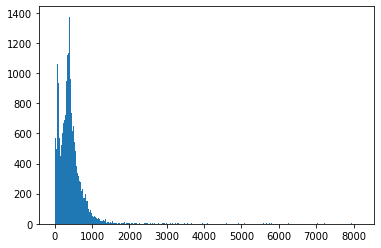

In [135]:
plt.hist([len(x) for x in X],bins=700)
plt.show()

Since we can see that most of the data or text are less than 1000 words so ignore data have more than 1000 words data

In [136]:
nos = np.array([len(x) for x in X])
len(nos[nos>1050])

1381

In [137]:
maxlen = 1050
X = pad_sequences(X,maxlen=maxlen)

In [138]:
X[0]

array([   0,    0,    0, ...,    8,    1, 9441], dtype=int32)

In [139]:
# Adding +1 for unknown words
vocab_size = len(tokenizer.word_index) + 1

In [140]:
vocab_size

375374

In [141]:
DIM = 100
vocab = tokenizer.word_index
def get_weight_matrix(model):
    weight_matrix = np.zeros((vocab_size, DIM))
    
    for word,i in vocab.items():
        weight_matrix[i] = model.wv[word]
    
    return weight_matrix

In [142]:
embedding_vectors = get_weight_matrix(w2v_model)

In [143]:
embedding_vectors.shape

(375374, 100)

In [144]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [145]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1050, 100)         37537400  
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 37,654,777
Trainable params: 117,377
Non-trainable params: 37,537,400
_________________________________________________________________


In [146]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [147]:
model.fit(X_train, y_train, validation_split=0.3, epochs=5)

Epoch 1/5
737/737 [==============================] - 130s 174ms/step - loss: 0.1721 - acc: 0.9356 - val_loss: 0.1077 - val_acc: 0.9656
Epoch 2/5
737/737 [==============================] - 127s 173ms/step - loss: 0.0755 - acc: 0.9747 - val_loss: 0.1666 - val_acc: 0.9226
Epoch 3/5
737/737 [==============================] - 127s 173ms/step - loss: 0.0627 - acc: 0.9780 - val_loss: 0.0312 - val_acc: 0.9908
Epoch 4/5
737/737 [==============================] - 127s 173ms/step - loss: 0.0198 - acc: 0.9942 - val_loss: 0.0271 - val_acc: 0.9913
Epoch 5/5
737/737 [==============================] - 127s 173ms/step - loss: 0.0149 - acc: 0.9952 - val_loss: 0.0213 - val_acc: 0.9931


In [148]:
# Accuracy on Test Dataset
y_pred = (model.predict(X_test) >= 0.5).astype(int)

In [149]:
accuracy_score(y_test, y_pred)

0.9932293986636971

In [150]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5911
           1       0.99      0.99      0.99      5314

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



# How to  classify on custom data

In [151]:
x = ['this is a news']

In [152]:
x = ['Govt making efforts to obtain files relating to Netaji: MoS Muraleedharan in Rajya Sabha']
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x,maxlen=1050)
(model.predict(x) >=0.5).astype(int)

array([[0]])

In [153]:
x=['''The Minister said in the Rajya Sabha that the UK has informed that 62 files on Bose are already available on the websites of the National Archives and the British Library.MoS Muraleedharan was replying to a question on the governments efforts to seek cooperation relating to the controversy over Netaji's death.
The Russian Government had informed the government of India that they were unable to find any documents in the Russian archives pertaining to Netaji. "The Russian government said that additional investigations were made to find the documents, based on request from the Indian side," he said.
ALSO READ: PM Modi unveils hologram statue of Netaji Subhas Chandra Bose at India Gate
The Japanese government has declassified two files on Netaji. "These files are part of their Archives and are available in the public domain. The government of Japan has transferred these files to India and they are retained in the National Archives of India," the minister said.
Muraleedharan informed the government of Japan has also said that if there are any additional documents relevant to the matter, those would be declassified as per their policies after a prescribed time period and based on an internal review mechanism.''']

In [154]:
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x,maxlen=1050)
(model.predict(x) >=0.5).astype(int)

array([[1]])

In [155]:
x = [''' 
Lata Mangeshkar’s unfortunate demise came as a jolt for the nation. The melody queen breathed her last on February 7 and the news sent down a wave of grief among the fans. The legendary singer was laid to rest at Shivaji Park, Mumbai with full state honours. Post her cremation, the Bharatiya Janata Party (BJP) demanded a fitting memorial for the deceased singer at Shivaji Park. Later, on Tuesday, Maharashtra Navnirman Sena (MNS) spokesperson Sandeep Deshpande said that the park should not be held hostage to ugly party politics. Taking to Twitter, the MNS secretary wrote, “Dadar residents have fought for long to protect the Chhatrapati Shivaji Maharaj Park from encroachment. They want the park to remain an open playground. It is my ardent appeal that Shivaji Park should not be sacrificed for petty party politics.”
Commenting on the same, Lata Mangeshkar’s brother Hridaynath Mangeshkar said that the politics which is going on concerning the singer's memorial should be immediately stopped as the family doesn’t support it. “Earlier, Aaditya Thackeray and Uddhav Thackeray came up with a proposal to Lata Mangeshkar for a musical institute on her name and she gave a nod to it. We want that legacy to continue and her musical skills to be kept alive. If we want to celebrate her legacy we will support the music institute and not the memorial,” said Hridaynath Mangeshkar. 
Amid the ongoing issue, Cabinet minister Aaditya Thackeray said, “Any decision on a memorial will have to be considered after consultation with the Mangeshkar family. And, more importantly, it should be done in a way to match her high stature so as to do justice to Lata Mangeshkar”, as per a report in Indian Express. 
''']

In [156]:
x = tokenizer.texts_to_sequences(x)
print(x)
x = pad_sequences(x,maxlen=1050)
print(x)
(model.predict(x) >=0.5).astype(int)

[[7007, 15302, 289, 17, 4, 31477, 9, 1, 488, 1, 64783, 5446, 57275, 52, 89, 8, 740, 2116, 5, 1, 97, 518, 161, 4, 3284, 3, 13156, 274, 1, 2380, 1, 9398, 4787, 14, 2943, 2, 1155, 26, 2208, 19698, 13, 476, 64, 190086, 387, 52, 19889, 1, 33711, 32731, 112, 29546, 2399, 4, 13855, 3851, 9, 1, 9532, 4787, 26, 2208, 437, 8, 278, 90022, 368424, 3692, 86290, 284167, 20, 7, 1, 2208, 100, 25, 22, 385, 5972, 2, 5554, 112, 985, 368, 2, 300, 1, 201, 606, 1178, 23, 2158, 9, 270, 2, 626, 1, 2208, 24, 27328, 31, 165, 1, 2208, 2, 909, 30, 447, 20990, 15, 11, 157, 11422, 1714, 7, 2208, 100, 25, 22, 11966, 9, 7837, 112, 985, 35787, 7920, 8, 1, 229, 2826, 20, 7, 1, 985, 48, 11, 127, 8, 3279, 1, 3851, 100, 22, 652, 1716, 17, 1, 312, 2743, 145, 15, 129116, 5, 289, 66, 13, 4, 1199, 2, 9, 4, 13850, 2121, 8, 52, 644, 5, 50, 546, 4, 11248, 2, 15, 34, 165, 7, 3537, 2, 403, 5, 52, 13850, 6648, 2, 22, 1635, 5020, 54, 34, 165, 2, 4259, 52, 3537, 34, 38, 145, 1, 4104, 2121, 5, 25, 1, 3851, 35787, 20, 1343, 1, 1935, 41

array([[0]])

In [157]:
import pickle 
# open a file, where you ant to store the data
file = open('LSTM_model.pkl', 'wb')

# dump information to that file
pickle.dump(model, file)

INFO:tensorflow:Assets written to: ram://d3009797-338e-41f9-8b35-aa4b696725c2/assets


INFO:tensorflow:Assets written to: ram://d3009797-338e-41f9-8b35-aa4b696725c2/assets


In [158]:
import pickle 
# open a file, where you ant to store the data
file = open('word2vec_lstm_model.pkl', 'wb')

# dump information to that file
pickle.dump(model, file)

INFO:tensorflow:Assets written to: ram://61cd0527-acf5-4da4-810c-213fd7cd11c8/assets


INFO:tensorflow:Assets written to: ram://61cd0527-acf5-4da4-810c-213fd7cd11c8/assets


In [159]:
from joblib import dump, load
dump(model, 'wordToVec_lstm_Model.joblib') 

INFO:tensorflow:Assets written to: ram://315c8261-6b4d-49ca-b028-332032436c48/assets


INFO:tensorflow:Assets written to: ram://315c8261-6b4d-49ca-b028-332032436c48/assets


['wordToVec_lstm_Model.joblib']

In [161]:
from joblib import dump, load
import numpy as np
model_lstm = load('wordToVec_lstm_Model.joblib') 

x = ['Govt making efforts to obtain files relating to Netaji: MoS Muraleedharan in Rajya Sabha']
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x,maxlen=1050)
(model_lstm.predict(x) >=0.5).astype(int)
# model_lstm.predict(x)

array([[0]])

In [163]:
from joblib import dump, load
import numpy as np
model_lstm = load('wordToVec_lstm_Model.joblib') 

x = [''' The Karnataka High Court on Thursday said that it is considering whether wearing a Hijab comes within Fundamental Rights. "We are considering the issue of whether the wearing of headscarf comes within the Fundamental Rights. We are also considering whether wearing a headscarf is an essential part of the religious practice," a three-judge bench headed by Chief Justice Ritu Raj Awasthi said while hearing petitions questioning the ban on the wearing of hijabs by students in schools and colleges. Senior advocate Devdatt Kamat, appearing for the petitioners from Kundapura, said that there is an urgency in the case and "requested that some interim arrangement be worked out by this bench" as students' exams are to be held in March. Earlier on Wednesday, Justice Krishna S Dixit, who was hearing the case, referred the petitions to a larger bench citing constitutional questions. Meanwhile, police in Delhi detained All India Students Association (AISA) workers who were marching towards Karnataka Bhawan to protest against the Karnataka government's dress code order.
considering the seriousness of the situation and to prevent the confrontation in Bengaluru, the administration has clamped prohibitory orders for two weeks. The hijab protests began last month at the Government Girls PU College in Udupi when students alleged that they had been barred from classes for insisting on wearing hijab. Protests for and against the 'hijab' then intensified in different parts of Karnataka and turned violent in some places.  
''']
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x,maxlen=1050)
(model_lstm.predict(x) >=0.5).astype(int)

array([[1]])

In [165]:
from joblib import dump, load
import numpy as np
model_lstm = load('wordToVec_lstm_Model.joblib') 
# Above is fake news taken 
x = [''' ASHINGTON, D.C. — A review of FBI Director James Comey’s professional history and relationships shows that the Obama cabinet leader — now under fire for his handling of the investigation of Hillary Clinton — is deeply entrenched in the big-money cronyism culture of Washington, D.C. His personal and professional relationships — all undisclosed as he announced the Bureau would not prosecute Clinton — reinforce bipartisan concerns that he may have politicized the criminal probe''']
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x,maxlen=1050)
(model_lstm.predict(x) >=0.5).astype(int)

array([[0]])

In [166]:
from joblib import dump, load
import numpy as np
model_lstm = load('wordToVec_lstm_Model.joblib') 
# Above is fake news taken 
x = [''' Last year a mysterious shipment was caught smuggling Coronavirus from Canada. It was traced to Chinese agents working at a Canadian lab. Subsequent investigation by GreatGameIndia linked the agents to Chinese Biological Warfare Program from where the virus is suspected to have leaked causing the Wuhan Coronavirus outbreak.
Note: BuzzFeed Reporter Who Attacked GreatGameIndia’s Coronavirus Bioweapon Story, Fired For Plagiarism
The findings of this investigation has been corroborated by none other than the Bioweapons expert Dr. Francis Boyle who drafted the Biological Weapons Convention Act followed by many nations. The report has caused a major international controversy and is suppressed actively by a section of mainstream media. ''']
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x,maxlen=1050)
(model_lstm.predict(x) >=0.5).astype(int)

array([[0]])